<a href="https://colab.research.google.com/github/ahshah322/IMDB-Movie-Ratings-Analysis/blob/main/notebooks/IMDB_Movie_Ratings_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook presents an **IMDB Movie Ratings Analysis** project, created using **Python, Pandas, NumPy, Seaborn, and Matplotlib**.  It explores a dataset of popular movies to uncover patterns and insights related to ratings, genres, budgets, revenues, runtimes, and more.  The analysis includes various visualizations such as bar charts, scatter plots, boxplots, and heatmaps to better understand the relationships  between key movie features.  

By the end of this notebook, you will gain a clear overview of how factors like genre, runtime, and production budgets influence IMDB ratings, along with identifying top movies, directors, and general trends within the dataset.


### Import Libraries and Setup

In this section, the essential Python libraries for data analysis and visualization are imported, including **Pandas**, **NumPy**, **Matplotlib**, and **Seaborn**. Basic **display settings** are configured to ensure consistent, clean, and visually appealing plots throughout the notebook. The `sns.set()` function applies a white grid style, while the figure DPI is increased for sharper, higher-quality visualizations.

In [ ]:
# Imports & Display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 110


### Load and Preview Dataset

In this section, the IMDB movie dataset is loaded from a CSV file using **Pandas**. Only the most relevant columns—such as movie title, year, rating, genre, budget, and cast—are retained for analysis. This ensures a cleaner and more focused dataset. Finally, the code prints the selected columns and displays the first few rows to verify that the data has been loaded correctly.

In [ ]:
# Load data & preview
df = pd.read_csv('/content/movies.csv')

# Columns we want (already matching)
wanted = ['rank', 'name', 'year', 'rating', 'genre', 'certificate',
          'run_time', 'tagline', 'budget', 'box_office', 'casts',
          'directors', 'writers']

# Keep only available requested columns
keep_cols = [c for c in wanted if c in df.columns]
df = df[keep_cols].copy()

print("Columns kept:", df.columns.tolist())
df.head()


Columns kept: ['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time', 'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers']


,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


### Define Helper Cleaning Functions

This section defines two helper functions to clean and standardize the dataset:

- **`parse_money(x)`**: Converts budget or box office strings (like `"$12.5M"`, `"€300K"`, `"12000000"`) into numeric float values. It handles various formats, including abbreviations for thousands (**K**), millions (**M**), and billions (**B**), ensuring consistent numerical representation for financial data.  
- **`parse_runtime(x)`**: Extracts and converts movie runtime strings (like `"2h 22min"` or `"142 min"`) into total minutes as integers.  

These functions help prepare the dataset for accurate numerical analysis and visualization.

In [ ]:
# Helper cleaning functions (money parsing and runtime parsing)
def parse_money(x):
    """
    Convert strings like '$12,345,678', '€1.2M', '£300K', '12000000' to numeric (float).
    Handles K (thousand), M (million), B (billion). Returns np.nan if parsing fails.
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip()
    if s == '' or s.lower() in ['n/a','none','-']:
        return np.nan
    # remove commas and spaces
    s = s.replace(',', '').replace(' ', '')
    m = re.match(r'^[^\d\-]*(-?\d+(?:\.\d+)?)([KMBkmb])?[^\d]*$', s)
    if m:
        num = float(m.group(1))
        mul = m.group(2)
        if mul:
            mul = mul.upper()
            if mul == 'K':
                return num * 1_000
            if mul == 'M':
                return num * 1_000_000
            if mul == 'B':
                return num * 1_000_000_000
        return num
    # fallback: extract digits
    digits = re.findall(r'-?\d+\.?\d*', s)
    if digits:
        return float(digits[0])
    return np.nan

def parse_runtime(x):
    """
    Convert runtime strings like '2h 22min', '142 min', '142min', '142' -> minutes (int).
    """
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()
    m = re.match(r'(?:(\d+)\s*h(?:ours?)?)?\s*(?:(\d+)\s*m(?:in(?:ute)?s?)?)?', s)
    if m:
        hours = m.group(1)
        mins = m.group(2)
        total = 0
        if hours:
            total += int(hours) * 60
        if mins:
            total += int(mins)
        if total > 0:
            return total
    m2 = re.search(r'(\d+)', s)
    if m2:
        return int(m2.group(1))
    return np.nan


### Apply Cleaning and Normalize Columns

This section standardizes column data types and applies the helper cleaning functions to key fields. Steps include:
- Converting `rating`, `year`, and `rank` to numeric types (with nullable integer support where appropriate).
- Parsing monetary fields (`budget`, `box_office`) into numeric values using `parse_money`.
- Converting `run_time` into total minutes using `parse_runtime`.
- Extracting a single `primary_genre` for easier grouping and analysis.
- Finally, a quick sanity preview shows the main columns to confirm changes.

Run this cell after the helper functions and dataset have been loaded.

In [ ]:
# Apply cleaning: money, runtime, rating types, year etc.
# Normalize column types
if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

# Clean budget and box_office
if 'budget' in df.columns:
    df['budget_parsed'] = df['budget'].apply(parse_money)

if 'box_office' in df.columns:
    df['box_office_parsed'] = df['box_office'].apply(parse_money)

# Run time to minutes
if 'run_time' in df.columns:
    df['run_time_min'] = df['run_time'].apply(parse_runtime)

# Extract primary genre (first genre mentioned) for simpler grouping
if 'genre' in df.columns:
    df['primary_genre'] = df['genre'].astype(str).apply(lambda s: s.split(',')[0].strip() if s != 'nan' else np.nan)

# Ensure rank is numeric if present
if 'rank' in df.columns:
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce').astype('Int64')

# Quick sanity output
df[['name','rank'] + [c for c in ['rating','year','primary_genre','run_time_min','budget_parsed','box_office_parsed'] if c in df.columns]].head()


,name,rank,rating,year,primary_genre,run_time_min,budget_parsed,box_office_parsed
0,The Shawshank Redemption,1,9.3,1994,Drama,142.0,25000000.0,2.888450e+07
1,The Godfather,2,9.2,1972,Crime,175.0,6000000.0,2.503418e+08
2,The Dark Knight,3,9.0,2008,Action,152.0,185000000.0,1.006234e+09
3,The Godfather Part II,4,9.0,1974,Crime,202.0,13000000.0,4.796192e+07
4,12 Angry Men,5,9.0,1957,Crime,96.0,350000.0,9.550000e+02


### Removing Incomplete or Irrelevant Records

In this section, the dataset is refined by removing rows that lack essential information required for meaningful analysis.  
The cleaning steps include:
- Keeping only movies that have a **valid title (`name`)**.  
- Retaining entries that include at least a **rating** or a **release year**, ensuring each remaining record contributes useful analytical data.  
- Resetting the DataFrame index after filtering for a clean and continuous sequence.  

This step helps maintain data quality and reliability before moving on to visual analysis.


In [ ]:
# Drop rows that have no essential info (optional)
# We'll keep rows that at least have name and rating
df_clean = df.copy()
df_clean = df_clean[df_clean['name'].notna()]
# keep rows with rating or year (helps many plots)
df_clean = df_clean[df_clean['rating'].notna() | df_clean['year'].notna()]
df_clean.reset_index(drop=True, inplace=True)
print("Rows after basic cleaning:", len(df_clean))


Rows after basic cleaning: 250


### Analysis 1 – Top 10 Movies by Rating

This section identifies and visualizes the **top 10 highest-rated movies** in the dataset.  
The data is first sorted by the `rating` column in descending order to get the best-rated films. Then, a **horizontal bar chart** is plotted using **Seaborn** to clearly show how the ratings compare across these top titles.

This visualization provides a quick overview of the most critically acclaimed movies in the dataset based on IMDB ratings.


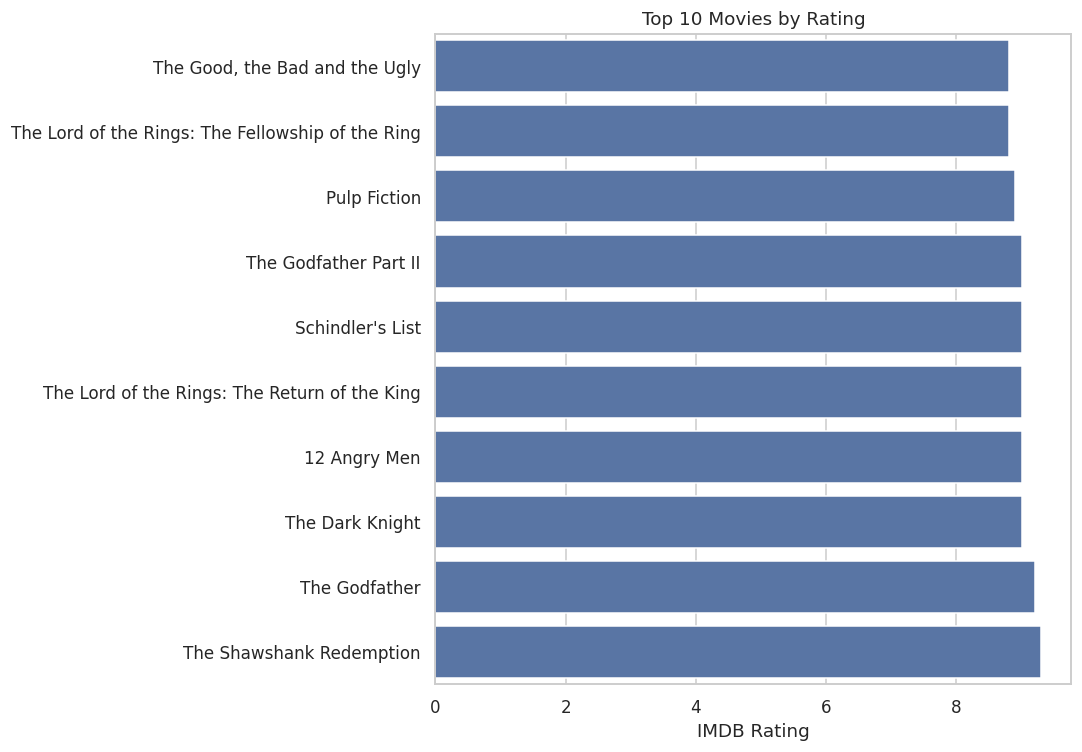

In [ ]:
# Analysis 1: Top 10 movies by rating (horizontal bar)
top10 = df_clean.sort_values(by='rating', ascending=False).head(10)
top10 = top10.sort_values('rating')  # sort for barh
plt.figure(figsize=(10,7))
sns.barplot(x='rating', y='name', data=top10)
plt.title('Top 10 Movies by Rating')
plt.xlabel('IMDB Rating')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Analysis 2 – Distribution of IMDB Ratings

This section visualizes the **overall distribution of movie ratings** in the dataset.  
A **histogram with a Kernel Density Estimate (KDE)** curve is used to display how ratings are spread across all movies.  
The plot helps identify whether most movies tend to receive high, moderate, or low ratings, providing insights into the general rating trends of the dataset.

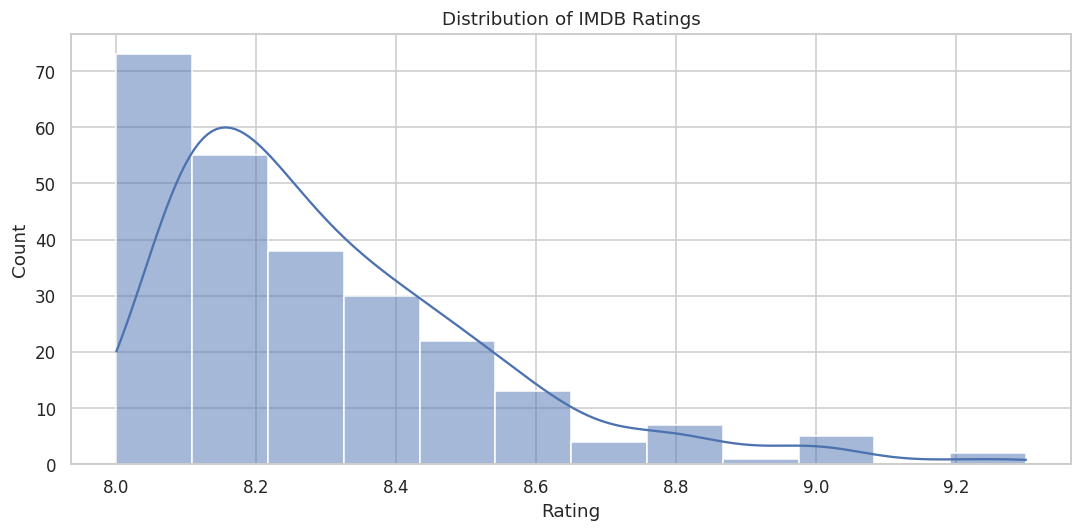

In [ ]:
# Analysis 2: Distribution of ratings (hist + KDE)
plt.figure(figsize=(10,5))
sns.histplot(df_clean['rating'].dropna(), bins=12, kde=True)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()

### Analysis 3 – Top 10 Years with the Most Movies

This section explores which years in the dataset produced the **highest number of movies**.  
By counting the number of films released each year and selecting the **top 10 most active years**, a vertical bar chart is created to visualize production trends over time.  

This analysis highlights periods of increased film output and can reveal trends such as growth in movie production or peaks tied to specific cinematic eras.

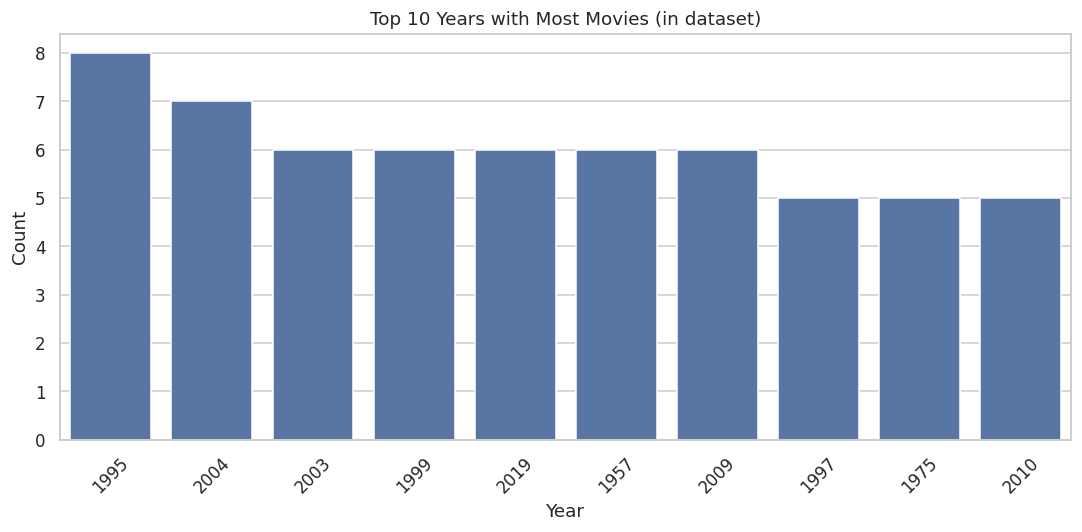

In [ ]:
# Analysis 3: Top years with most movies (countplot, vertical bar)
if 'year' in df_clean.columns:
    top_years = df_clean['year'].value_counts().nlargest(10).index.astype(str)
    plt.figure(figsize=(10,5))
    sns.countplot(x='year', data=df_clean[df_clean['year'].isin(top_years.astype(int))],
                  order=[int(y) for y in top_years])
    plt.title('Top 10 Years with Most Movies (in dataset)')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Analysis 4 – Rating Distribution by Genre

This section analyzes how **IMDB ratings vary across different movie genres**.  
A **boxplot** is used to display the spread and central tendency of ratings for the **top 8 most common genres** in the dataset.  
Each box represents the range of ratings for a genre, highlighting differences in audience or critic reception.  

This visualization helps identify which genres tend to receive higher or more consistent ratings.


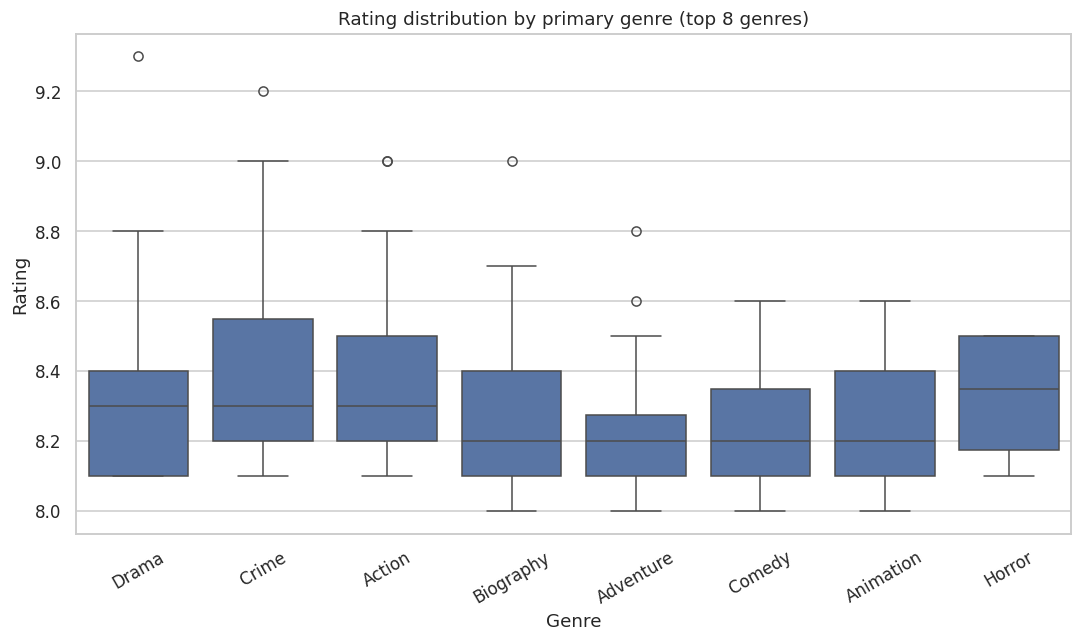

In [ ]:
# Analysis 4: Ratings by primary genre (boxplot)
if 'primary_genre' in df_clean.columns:
    # take top N genres for clarity
    top_genres = df_clean['primary_genre'].value_counts().nlargest(8).index
    plt.figure(figsize=(10,6))
    sns.boxplot(x='primary_genre', y='rating', data=df_clean[df_clean['primary_genre'].isin(top_genres)])
    plt.title('Rating distribution by primary genre (top 8 genres)')
    plt.xlabel('Genre')
    plt.ylabel('Rating')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


### Analysis 5 – Relationship Between Budget and Box Office Revenue

This section examines the **correlation between a movie’s budget and its box office earnings**.  
A **scatter plot** with both axes on a **logarithmic scale** is used to visualize how production budgets relate to financial performance.  
Each bubble represents a movie, and the **bubble size indicates its IMDB rating** — allowing quick insights into both popularity and quality.  

A **regression line** (gray dashed line) is added to highlight the general trend, helping identify whether higher budgets typically lead to higher box office returns.


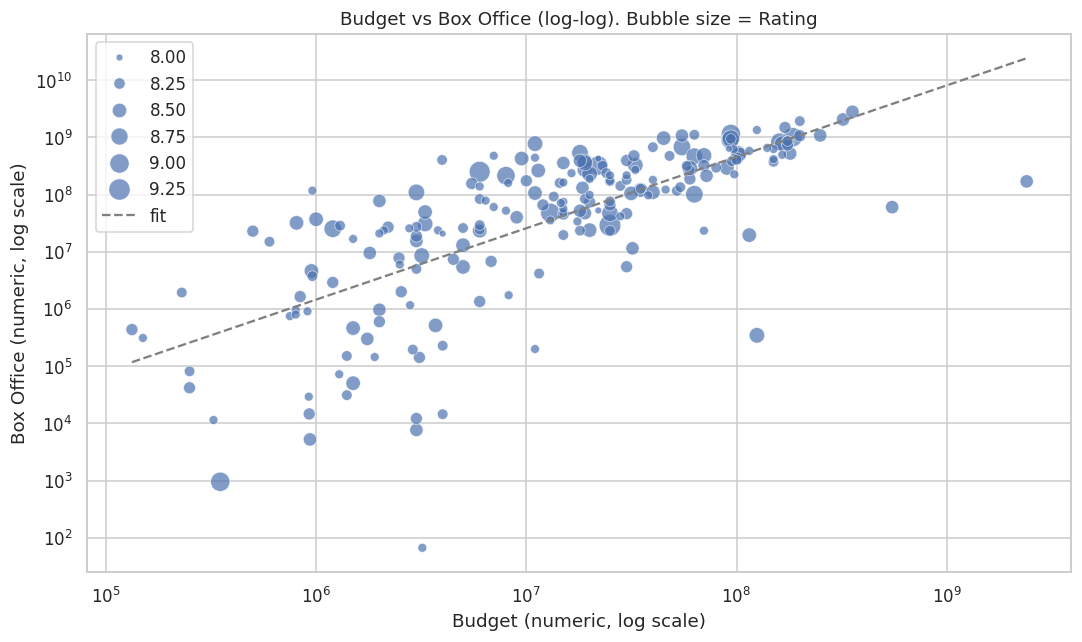

In [ ]:
# Analysis 5: Budget vs Box Office (scatter with log scale + regression)
if 'budget_parsed' in df_clean.columns and 'box_office_parsed' in df_clean.columns:
    sub = df_clean[['name','budget_parsed','box_office_parsed','rating']].dropna(subset=['budget_parsed','box_office_parsed'])
    if len(sub) > 10:
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='budget_parsed', y='box_office_parsed', size='rating', sizes=(20,200), data=sub, alpha=0.7)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Budget (numeric, log scale)')
        plt.ylabel('Box Office (numeric, log scale)')
        plt.title('Budget vs Box Office (log-log). Bubble size = Rating')
        # Add a simple linear fit on log values
        try:
            xlog = np.log(sub['budget_parsed'])
            ylog = np.log(sub['box_office_parsed'])
            m, b = np.polyfit(xlog, ylog, 1)
            xs = np.linspace(xlog.min(), xlog.max(), 100)
            plt.plot(np.exp(xs), np.exp(m*xs + b), linestyle='--', label='fit', color='gray')
            plt.legend()
        except Exception:
            pass
        plt.tight_layout()
        plt.show()

### Analysis 6 – Relationship Between Runtime and Rating

This section explores the **relationship between a movie’s runtime and its IMDb rating**.  
A **scatter plot with a regression line** is used to visualize whether longer or shorter movies tend to receive higher ratings.  
Each point represents a movie, with its runtime (in minutes) plotted against its rating, while the regression line highlights the **overall trend** in the data.


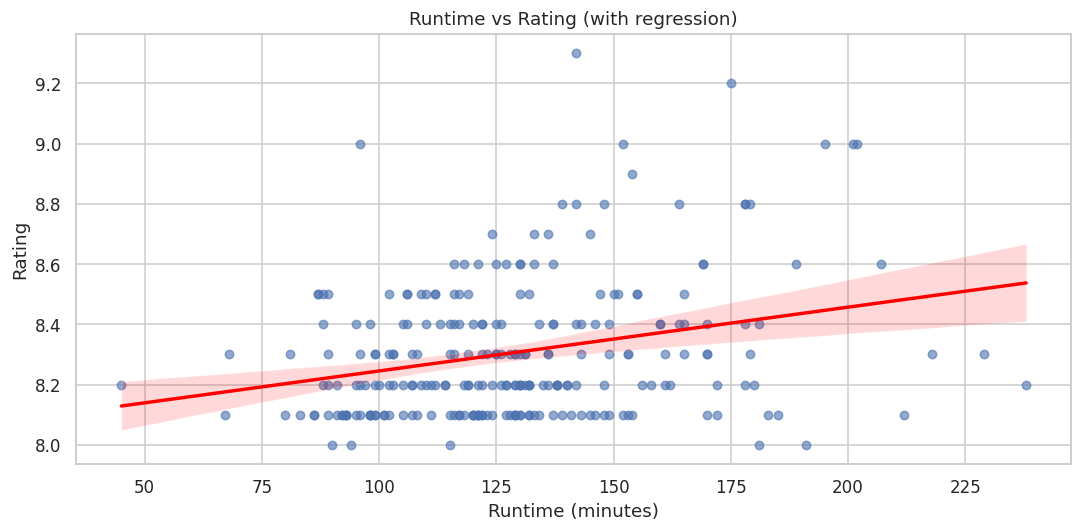

In [ ]:
# Analysis 6: Runtime vs Rating (scatter + regression)
if 'run_time_min' in df_clean.columns and 'rating' in df_clean.columns:
    sub = df_clean.dropna(subset=['run_time_min','rating'])
    plt.figure(figsize=(10,5))
    sns.regplot(x='run_time_min', y='rating', data=sub, scatter_kws={'s':30, 'alpha':0.6}, line_kws={'color':'red'})
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Rating')
    plt.title('Runtime vs Rating (with regression)')
    plt.tight_layout()
    plt.show()

### Analysis 7 – Top Directors by Number of Movies

This section identifies the **directors with the highest number of movies** in the dataset.  
To ensure accuracy, multiple directors listed for a single movie are **split and counted individually**.  
The data is visualized using a **horizontal bar chart**, displaying the **top 10 directors** based on the total number of movies they directed, offering insight into which filmmakers are most prolific within the dataset.


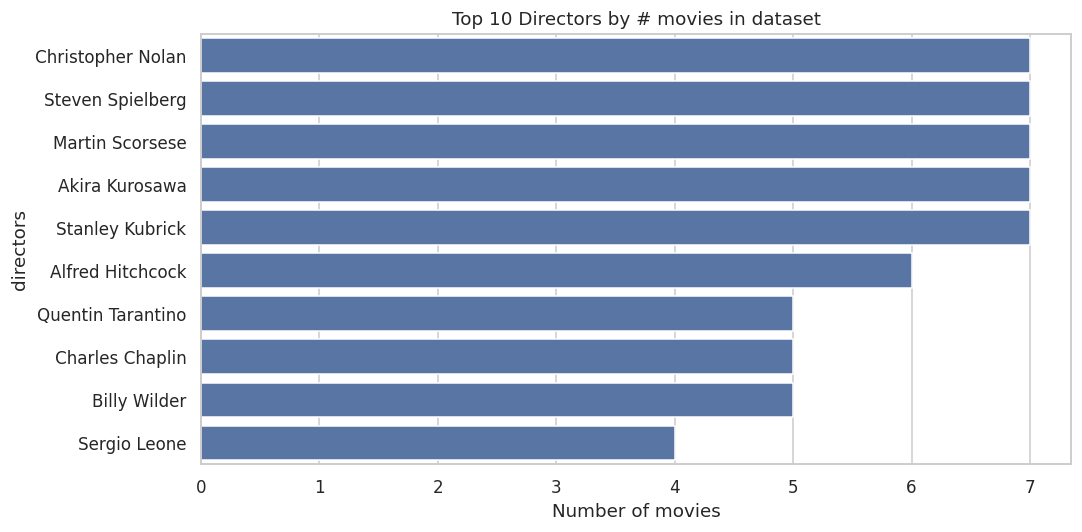

In [ ]:
# Analysis 7: Top directors by number of movies (countplot horizontal)
if 'directors' in df_clean.columns:
    # split multiple directors and explode
    dir_series = df_clean['directors'].astype(str).str.split(',').explode().str.strip()
    top_dirs = dir_series.value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_dirs.values, y=top_dirs.index)
    plt.title('Top 10 Directors by # movies in dataset')
    plt.xlabel('Number of movies')
    plt.tight_layout()
    plt.show()

### Analysis 8 – Correlation Heatmap for Numeric Columns

This section visualizes the **correlations between key numeric variables** in the dataset, such as **rating, runtime, budget, and box office**.  
A **heatmap** is used to display the strength and direction of relationships between these variables, helping to identify which factors may be related to higher ratings or financial success.


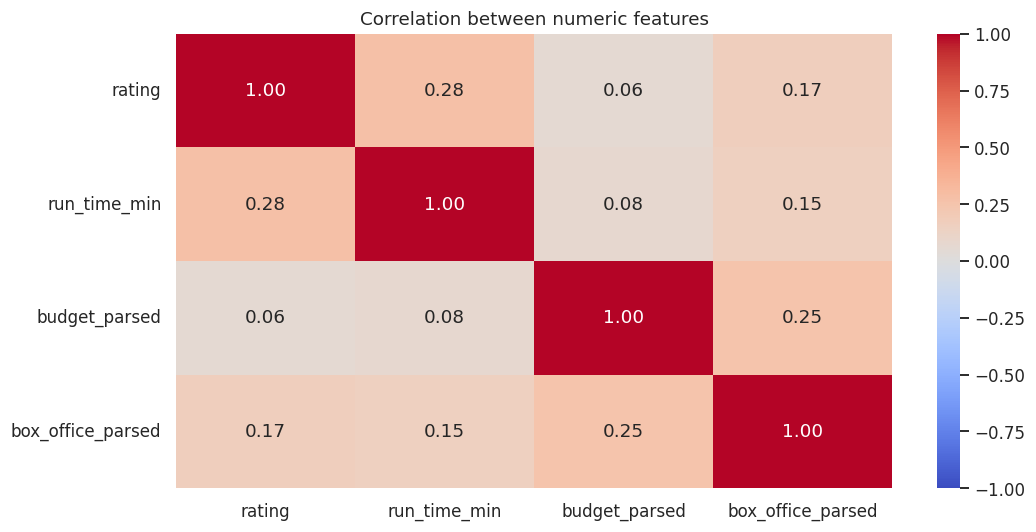

In [ ]:
# Analysis 8: Correlation heatmap for numeric columns (rating, run_time, budget, box_office)
num_cols = []
for c in ['rating','run_time_min','budget_parsed','box_office_parsed']:
    if c in df_clean.columns:
        num_cols.append(c)

if len(num_cols) >= 2:
    plt.figure(figsize=(10,5))
    corr = df_clean[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between numeric features')
    plt.tight_layout()
    plt.show()

### Analysis 9 – Certificate Distribution (Pie Chart)

This section visualizes the **distribution of movie certificates or ratings** (e.g., PG, R, G, etc.) using a **pie chart**.  
It highlights the top categories and groups the rest under “Other”, giving a quick overview of how movies in the dataset are classified by viewing age restrictions.

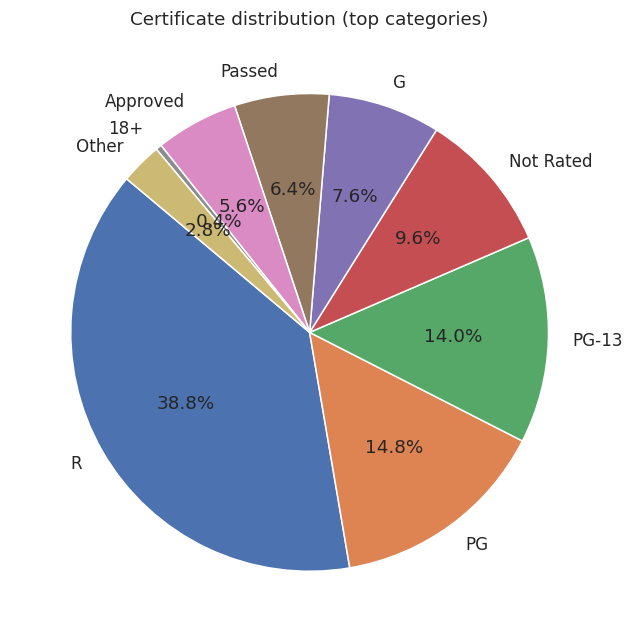

In [ ]:
# Analysis 9: Certificate distribution (pie chart)
if 'certificate' in df_clean.columns:
    cert_counts = df_clean['certificate'].fillna('Unknown').value_counts()
    # show top 8 certificate categories + other
    top_certs = cert_counts.head(8)
    others = cert_counts.iloc[8:].sum()
    labels = top_certs.index.tolist()
    sizes = top_certs.values.tolist()
    if others > 0:
        labels.append('Other')
        sizes.append(others)
    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Certificate distribution (top categories)')
    plt.tight_layout()
    plt.show()

### Conclusion

* Movies directed by well-known directors tend to have higher IMDb ratings.
* Longer runtimes don’t always guarantee higher ratings.
* Higher metascores usually align with higher IMDb ratings, indicating critical and audience agreement.
* The dataset shows that classic movies (1990s–2000s) still dominate top IMDb rankings.